In [2]:
%matplotlib inline 
import keras as K
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GaussianNoise, Cropping2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, TensorBoard

from keras import backend as K

Using TensorFlow backend.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd95664b550>]], dtype=object)

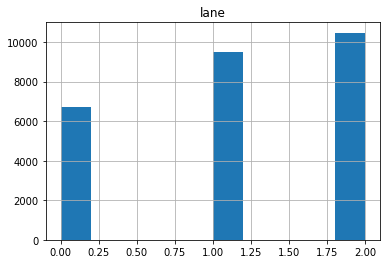

In [3]:
TRAIN_VAL_RATIO=0.9
DATASET_CSV_PATH='dataset.csv'
MAX_NUMBER_OF_LANES=3

samples=pd.read_csv(DATASET_CSV_PATH)
samples=samples[samples['lane']>=0]
samples=samples[samples['lane']<MAX_NUMBER_OF_LANES]
nr_train_samples=int(len(samples)*TRAIN_VAL_RATIO)
nr_val_samples=len(samples)-nr_train_samples
samples.hist()



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd9571851d0>]], dtype=object)

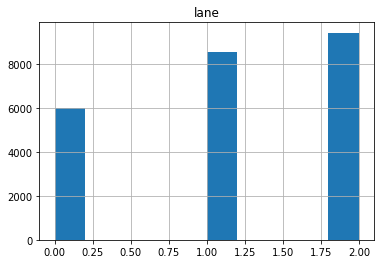

In [4]:
train_samples=samples[0:nr_train_samples]
train_samples.hist()

In [5]:
train_samples=samples[0:nr_train_samples].groupby('lane').apply(pd.DataFrame.sample, n=int(nr_train_samples/MAX_NUMBER_OF_LANES),replace=True).reset_index(drop=True).sample(frac=1, replace=False)
train_samples['lane']=train_samples['lane'].astype('str')
train_samples.head()

,img_path,lane
21292,20190509_hawkeye_first_data_collection/image_0...,2
12341,20190509_hawkeye_first_data_collection/image_0...,1
11981,20190509_hawkeye_first_data_collection/image_0...,1
12078,20190509_hawkeye_first_data_collection/image_0...,1
7561,20190509_hawkeye_first_data_collection/image_0...,0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd9571d0780>]], dtype=object)

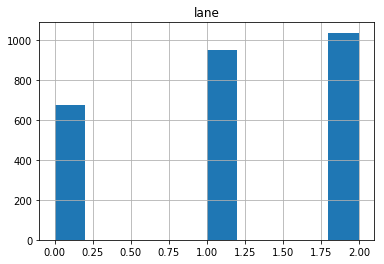

In [6]:
val_samples=samples[nr_train_samples:]
val_samples.hist()

In [7]:
val_samples=samples[nr_train_samples:].groupby('lane').apply(pd.DataFrame.sample, n=int(nr_val_samples/MAX_NUMBER_OF_LANES),replace=True).reset_index(drop=True).sample(frac=1, replace=False)
val_samples=val_samples[val_samples['lane']<3]
val_samples['lane']=val_samples['lane'].astype('str')
val_samples.head()


,img_path,lane
908,20190509_hawkeye_first_data_collection/image_0...,1
570,20190509_hawkeye_first_data_collection/image_0...,0
1931,20190509_hawkeye_first_data_collection/image_0...,2
1384,20190509_hawkeye_first_data_collection/image_0...,1
1536,20190509_hawkeye_first_data_collection/image_0...,1


In [8]:
train_samples.groupby('lane').count()

,img_path
lane,
0,8001
1,8001
2,8001


In [9]:
val_samples.groupby('lane').count()

,img_path
lane,
0,889
1,889
2,889


In [10]:
# dimensions of our images.
img_width, img_height = 640, 480
CROP_TOP=int(300)
CROP_BOTTOM=int(30)

train_data_dir = '/home/af1n/work/datasets/caltech/caltech-lanes-categories'
validation_data_dir = '/home/af1n/work/datasets/caltech/caltech-lanes-categories'
nb_train_samples = nr_train_samples
nb_validation_samples = nr_val_samples
batch_size = 8

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_height, img_width)
else:
    input_shape = (img_height, img_width, 3)
    
model = Sequential()
model.add(Cropping2D(cropping=((CROP_TOP, CROP_BOTTOM), (0, 0)), input_shape=input_shape))
model.add(GaussianNoise(0.5))

#model.add(GaussianNoise(0.5, input_shape=input_shape))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (1, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(3))
model.add(Activation('softmax'))

In [11]:
#model=darknet()
sgd = optimizers.SGD(lr=0.00001, decay=1e-6, momentum=0.9, nesterov=True)
adam = optimizers.Adam(lr=0.00001, decay=1e-6)

model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d_1 (Cropping2D)    (None, 150, 640, 3)       0         
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 150, 640, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 148, 638, 128)     3584      
_________________________________________________________________
activation_1 (Activation)    (None, 148, 638, 128)     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 146, 636, 128)     147584    
_________________________________________________________________
activation_2 (Activation)    (None, 146, 636, 128)     0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 318, 128)     

In [13]:
MODEL_SAVE_PATH='models/weights.{epoch:02d}-{val_loss:.2f}-{acc:.2f}.hdf5'

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    shear_range=0.4,
    zoom_range=0.1,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.1,
    horizontal_flip=False,
#    brightness_range=(0.25,1.85),
    channel_shift_range=130)
#)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator()

x_col='img_path'
y_col='lane'
train_generator = train_datagen.flow_from_dataframe(
    train_samples,
    x_col=x_col,
    y_col=y_col,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_dataframe(
    val_samples,
    x_col=x_col,
    y_col=y_col,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

callbacks = [#EarlyStopping(monitor='val_loss', patience=10),
             CSVLogger('./train.log', separator=',', append=False),
             #TensorBoard(log_dir='./tensorboard', histogram_freq=100, batch_size=32, write_graph=True, write_grads=True, write_images=True, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None, update_freq='epoch'),
             ModelCheckpoint(filepath=MODEL_SAVE_PATH, monitor='acc', verbose=True, save_best_only=False, mode='max')]

Found 24003 validated image filenames belonging to 3 classes.
Found 2667 validated image filenames belonging to 3 classes.


[ 0.  1.  0.]
[ 0.  0.  1.]
[ 0.  0.  1.]
[ 1.  0.  0.]
[ 0.  0.  1.]
[ 0.  0.  1.]
[ 0.  1.  0.]


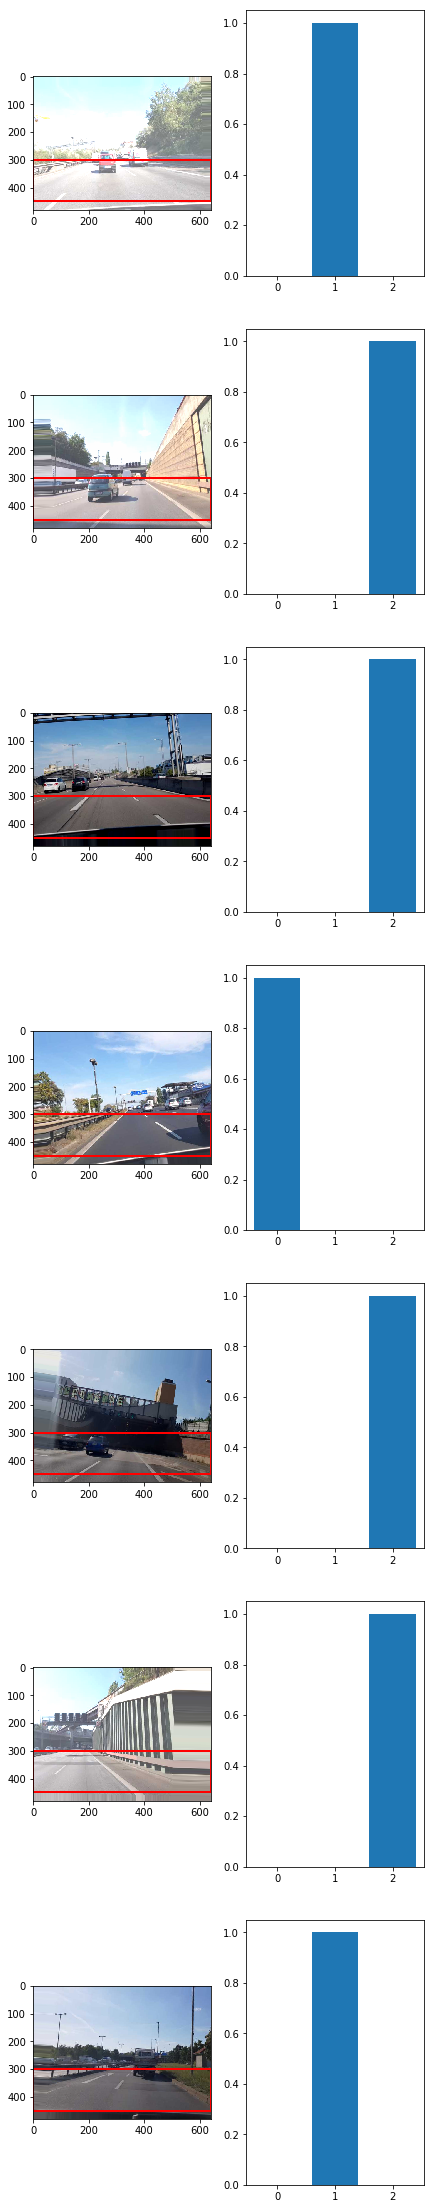

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import numpy as np
sample_data=next(train_generator)
sample_images=sample_data[0]
sample_images=sample_images.astype('uint8')
sample_lane_numbers=sample_data[1]

fig, ax = plt.subplots(nrows=7, ncols=2, figsize=(7,40))
rowid=0

for row in ax:
    rect = patches.Rectangle((0,CROP_TOP),img_width,img_height-CROP_BOTTOM-CROP_TOP,linewidth=2,edgecolor='r',facecolor='none')
    row[0].add_patch(rect)
    row[0].imshow(sample_images[rowid])
    print(sample_lane_numbers[rowid])
    row[1].bar([0,1,2], sample_lane_numbers[rowid])
    rowid=rowid+1

In [34]:
sample_images[0]


array([[[213, 255, 255],
        [213, 255, 255],
        [213, 255, 255],
        ..., 
        [215, 207, 188],
        [215, 207, 188],
        [215, 207, 188]],

       [[213, 255, 255],
        [213, 255, 255],
        [213, 255, 255],
        ..., 
        [215, 207, 188],
        [215, 207, 188],
        [215, 207, 188]],

       [[213, 255, 255],
        [213, 255, 255],
        [213, 255, 255],
        ..., 
        [215, 207, 188],
        [215, 207, 188],
        [215, 207, 188]],

       ..., 
       [[216, 212, 213],
        [209, 205, 206],
        [209, 205, 206],
        ..., 
        [123, 122, 127],
        [123, 122, 127],
        [123, 122, 127]],

       [[222, 218, 219],
        [211, 207, 208],
        [207, 203, 204],
        ..., 
        [123, 122, 127],
        [123, 122, 127],
        [123, 122, 127]],

       [[217, 213, 214],
        [214, 210, 211],
        [212, 208, 209],
        ..., 
        [123, 122, 127],
        [123, 122, 127],
        [123, 122,

In [49]:
epochs = 1000
iters_per_epoch=200
model.fit_generator(
    train_generator,
    callbacks=callbacks,
    steps_per_epoch=iters_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=200)
#    max_queue_size=64,
#    workers=24,
#    use_multiprocessing=True)

Epoch 1/1000
 16/200 [=>............................] - ETA: 2:28 - loss: 4.7058 - acc: 0.3125

KeyboardInterrupt: 